# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [152]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [153]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import requests
import urllib2
import bs4
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

import statsmodels.api as sm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import requests
import urllib2
import bs4
from bs4 import BeautifulSoup

from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

import statsmodels.api as sm

%matplotlib inline


Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above

In [154]:
## YOUR CODE HERE

title=[]
company=[]
location=[]
salary=[]
summary=[]

def scraper(URL,city):
    dom = BeautifulSoup(requests.get(URL).text,"lxml")

    jobDivs = dom.find_all("div", {"class":"result","class":"row"})

    for div in jobDivs:
        divSoup = BeautifulSoup(unicode.join(u'\n',map(unicode,div)),"lxml")

        #get title
        title.append(divSoup.find("a",{"data-tn-element":"jobTitle"})['title'])

        #get company
        company1 = divSoup.find("a",{"data-tn-element":"companyName"})
        company2 = divSoup.find("span",{"class":"company"})
        company3 = divSoup.find("span",{"itemprop":"name"})
        if(company1 != None):
            #print "1: ",company1.contents[-1].strip()
            company.append(company1.contents[-1].strip())
        elif(company2 != None):
            #print "2: ",company2.strip()
            company.append(company2.text.strip())
        elif(company3 != None):
            if(company3.string != None):
                #print "3a: ",company3.string.strip()
                company.append(company3.string.strip())
            else:
                #print "3b: ",company3.contents[-1].string.strip()
                if(company3.contents[-1].string != None):
                    company.append(company3.contents[-1].string.strip())
                else:
                    company.append("What:" + company3.contents[-1].text)
                    
        else:
            print "N/A"

        #get location 
        #locationString = divSoup.find("span",{"class":"location"}).string
        #if (locationString == None):
        #    locationString = divSoup.find("span",{"itemprop":"addressLocality"}).contents[0].strip()
        location.append(city)

        #get salary

        salaryItem = divSoup.find("span",{"class":"location"}).findNextSibling("div")
        salaryItem2 = divSoup.find("td",{"class":"snip"}).findChild('nobr')
        if (salaryItem != None):
            salary.append(salaryItem.text)
        elif(salaryItem2 != None):
            #print "nobr: ", salaryItem2.string
            salary.append(salaryItem2.string)
        else:
            salary.append(np.nan)

        #get summary

        #print divSoup.find("span",{"class":"summary"}).text
        #summary.append(divSoup.find("span",{"class":"summary"}).text)

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [155]:
max_results_per_city = 1000

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', "Atlanta","Seattle","Los+Angeles","Washington%2C+DC","Huntsville",
                 "San+Diego","Austin","Denver","St.+Louis","Boston","Portland","Philadelphia","Dallas","Houston","San+Antonio","Charlotte"]):
    print city
    for start in range(0, max_results_per_city, 10):
        print "Results: ", start
        url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l="+ city +"&start=" + str(start)
        scraper(url_template, city)   

Houston
Results:  0
Results:  10
Results:  20
Results:  30
Results:  40
Results:  50
Results:  60
Results:  70
Results:  80
Results:  90
Results:  100
Results:  110
Results:  120
Results:  130
Results:  140
Results:  150
Results:  160
Results:  170
Results:  180
Results:  190
Results:  200
Results:  210
Results:  220
Results:  230
Results:  240
Results:  250
Results:  260
Results:  270
Results:  280
Results:  290
Results:  300
Results:  310
Results:  320
Results:  330
Results:  340
Results:  350
Results:  360
Results:  370
Results:  380
Results:  390
Results:  400
Results:  410
Results:  420
Results:  430
Results:  440
Results:  450
Results:  460
Results:  470
Results:  480
Results:  490
Results:  500
Results:  510
Results:  520
Results:  530
Results:  540
Results:  550
Results:  560
Results:  570
Results:  580
Results:  590
Results:  600
Results:  610
Results:  620
Results:  630
Results:  640
Results:  650
Results:  660
Results:  670
Results:  680
Results:  690
Results:  700
Results: 

KeyboardInterrupt: 

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [156]:
print len(title)
print len(salary)
print len(location)
print len(salary)

1046
1046
1046
1046


In [157]:
length = len(title)-1

In [158]:
df = pd.DataFrame({'title':title[0:length], 'company':company[0:length], 'location':location[0:length], 'salary':salary[0:length]})

In [159]:
df.describe()

,company,location,salary,title
count,1045,1045,79,1045
unique,95,1,13,150
top,"Geosyntec Consultants, Inc.",Houston,"$60,000 - $95,000 a year",Computational Scientist
freq,122,1045,61,78


In [160]:
df = df.dropna()
df.head()

,company,location,salary,title
5,Oscar Technology,Houston,"$160,000 a year",Big Data Analytics Manager
20,Texas A&M University,Houston,"$70,000 a year",Bioinformatics Postdoctoral Fellow
25,Baylor College of Medicine,Houston,"$49,506 a year",Quality Assurance and Research Analyst
30,Gallup,Houston,\n Best places to work in Consultin...,Data Scientist – Predictive Analytics
38,Baylor College of Medicine,Houston,"$93,431 a year",Java Programmer


Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

In [161]:
yearly = pd.DataFrame(columns=('company', 'location', 'salary', 'title'))
for index, row in df.iterrows():
    if "a year" in row['salary']:
        yearly.loc[index] = row
#yearly

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [163]:
import re

for index, row in yearly.iterrows():
    if "-" in row['salary']:
        tokenized = row['salary'].split("-")
        #print "First: ",re.sub("[^0-9]", "", tokenized[0].strip("$")).strip()
        #print "Second: ",re.sub("[^0-9]", "", tokenized[1].strip("$")).strip()
        lower = int(re.sub("[^0-9]", "", tokenized[0]).strip())
        higher = int(re.sub("[^0-9]", "", tokenized[1]).strip())
        average = (higher + lower)/2
        yearly.loc[index][2] = average
    else:
        yearly.loc[index][2] = int(re.sub("[^0-9]", "", row['salary']).strip())
        
    yearly.loc[index][1] = re.sub("\d+","", row['location']).strip() 
    
yearly.head()

,company,location,salary,title
5,Oscar Technology,Houston,160000,Big Data Analytics Manager
20,Texas A&M University,Houston,70000,Bioinformatics Postdoctoral Fellow
25,Baylor College of Medicine,Houston,49506,Quality Assurance and Research Analyst
38,Baylor College of Medicine,Houston,93431,Java Programmer
85,MD ANDERSON CANCER CENTER,Houston,64500,Clinical Research Scientist


In [165]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

yearly['salary'] = yearly['salary'].astype(int)
print_full(yearly['salary'])

5       160000
20       70000
25       49506
38       93431
85       64500
122      67500
128      32454
176      54590
212      67632
248      77500
262      77500
278      77500
291      77500
305      77500
319      77500
334      77500
349      77500
364      77500
377      77500
393      77500
407      77500
422      77500
437      77500
452      77500
468      77500
483      77500
497      77500
512      77500
528      77500
542      77500
557      77500
572      77500
584      77500
596      77500
608      77500
620      77500
632      77500
644      77500
656      77500
668      77500
680      77500
692      77500
704      77500
716      77500
728      77500
740      77500
752      77500
764      77500
776      77500
788      77500
800      77500
812      77500
824      77500
836      77500
848      77500
860      77500
872      77500
885      77500
898      77500
911      77500
924      77500
937      77500
950      77500
963      77500
976      77500
989      77500
1002     7

### Save your results as a CSV

In [166]:
## YOUR CODE HERE
yearly.describe()

yearly.to_csv("/Users/Tamara/Desktop/indeed_salary_data",encoding='utf-8',index=False)

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [167]:
## YOUR CODE HERE
data = pd.read_csv('/Users/Tamara/Desktop/indeed_salary_data.csv')
data.head()

,company,location,salary,title
0,Texas A&M University,Houston,70000,Bioinformatics Postdoctoral Fellow
1,Baylor College of Medicine,Houston,86500,Senior Staff Scientist / Technical Director
2,Oscar Technology,Houston,160000,Big Data Analytics Manager
3,Baylor College of Medicine,Houston,93431,Java Programmer
4,Baylor College of Medicine,Houston,67632,Laboratory Manager


In [168]:
data = data.drop_duplicates()
data.count()

company     424
location    424
salary      424
title       424
dtype: int64

In [169]:
meanSalary = np.mean(data["salary"])

def HigherOrLower(salary):
    if salary > meanSalary:
        return 1
    else:
        return 0

data["HighLow"] = map(HigherOrLower,data["salary"])
#smdata = data
#smdata["Intercept"] = 1
data["Intercept"] = 1

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [170]:
meanSalary = np.mean(data["salary"])

def HigherOrLower(salary):
    if salary > meanSalary:
        return 1
    else:
        return 0

data["HighLow"] = map(HigherOrLower,data["salary"])
#smdata = data
#smdata["Intercept"] = 1
data["Intercept"] = 1

#### Thought experiment: What is the baseline accuracy for this model?

In [171]:
## YOUR CODE HERE

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [172]:
## YOUR CODE HERE
def categorizeTitles(string):
    title = string.lower()
    if("data scientist" in title):
        return 0
    elif("statistician" in title):
        return 1
    elif("data analyst" in title):
        return 2
    elif("data engineer" in title):
        return 3
    elif("research analyst" in title):
        return 4
    elif("software" in title or "engineer" in title or "developer" in title):
        return 5
    elif("analyst" in title):
        return 6
    elif("director" in title):
        return 7
    elif("manager" in title):
        return 8
    elif("scientist" in title):
        return 9
    else:
        return 10
    
categorizedTitles = map(categorizeTitles,data.title)
data["categorizedTitle"] = categorizedTitles
#smdata["categorizedTitle"] = categorizedTitles

In [173]:
def categorizeLevel(string):
    title = string.lower()
    if("junior" in title or "jr." in title):
        return 0
    elif("mid-level" in title):
        return 2
    elif("senior" in title or "sr." in title):
        return 1
    elif("principal" in title):
        return 2
    elif("lead" in title):
        return 3
    else:
        return 4
    
categorizedLevels = map(categorizeLevel,data.title)
data["categorizedLevel"] = categorizedLevels

In [174]:
locationData = data.groupby("location",as_index="False").count()
mostCommonLocation = locationData.idxmax()[1]
print "Most Common Location: ", mostCommonLocation

companyData = data.groupby("company",as_index="False").count()
mostCommonCompany = companyData.idxmax()[1]
print "Most Common Company: ", mostCommonCompany

titleData = data.groupby("categorizedTitle",as_index="False").count()
mostCommonTitle = titleData.idxmax()[1]
print "Most Common Categorized Title: ", mostCommonTitle


Most Common Location:  Boston
Most Common Company:  Workbridge Associates
Most Common Categorized Title:  0


In [175]:
categories = ["location"]
for category in categories:
    series = data[category]
    dummies = pd.get_dummies(series, prefix=category)
    data = pd.concat([data, dummies], axis=1)
    #if(categories != "company"):
        #smdata = pd.concat([smdata, dummies], axis = 1)
    
#delete most common location for colinearity
del data["location_"+mostCommonLocation]
#del data["company_"+mostCommonCompany]
#del data["categorizedTitle_"+str(mostCommonTitle)]

#del smdata["location_"+mostCommonLocation]
#del smdata["company_"+mostCommonCompany]
#del smdata["categorizedTitle_"+str(mostCommonTitle)]

#smdata

In [176]:
data.head()

,company,location,salary,title,HighLow,Intercept,categorizedTitle,categorizedLevel,location_Atlanta,location_Austin,...,location_Los+Angeles,location_New+York,location_Philadelphia,location_Portland,location_San+Antonio,location_San+Diego,location_San+Francisco,location_Seattle,location_St.+Louis,location_Washington%C+DC
0,Texas A&M University,Houston,70000,Bioinformatics Postdoctoral Fellow,0,1,10,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Baylor College of Medicine,Houston,86500,Senior Staff Scientist / Technical Director,0,1,7,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Oscar Technology,Houston,160000,Big Data Analytics Manager,1,1,8,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Baylor College of Medicine,Houston,93431,Java Programmer,0,1,10,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Baylor College of Medicine,Houston,67632,Laboratory Manager,0,1,8,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
X = data.iloc[:,8:]
y = data["HighLow"]
y.name = "Actual"

In [178]:
logit = sm.Logit(y, X)
result = logit.fit()
result.summary()

         Current function value: 0.595938
         Iterations: 35


/Users/Tamara/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Actual   No. Observations:                  424
Model:                          Logit   Df Residuals:                      406
Method:                           MLE   Df Model:                           17
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.1375
Time:                        13:02:08   Log-Likelihood:                -252.68
converged:                      False   LL-Null:                       -292.97
                                        LLR p-value:                 3.021e-10
============================================================================================
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
location_Atlanta            -0.8473      0.488     -1.736      0.082        -1.804     0.109
location_Austin                   0      0.707          0      1.000        -1.386     1.386
location_Charlotte          20.5444   1.45e+04      0.001      0.999     -2.83e+04  2.84e+04
location_Chicago             0.1542      0.321      0.480      0.631        -0.475     0.784
location_Dallas             -0.6931      0.612     -1.132      0.258        -1.893     0.507
location_Denver             -1.3218      0.563     -2.349      0.019        -2.425    -0.219
location_Houston            -2.3026      1.049     -2.195      0.028        -4.358    -0.247
location_Huntsville         18.3274   9544.344      0.002      0.998     -1.87e+04  1.87e+04
location_Los+Angeles        -0.5306      0.399     -1.331      0.183        -1.312     0.250
location_New+York                 0      0.289          0      1.000        -0.566     0.566
location_Philadelphia        0.1542      0.556      0.277      0.782        -0.936     1.245
location_Portland          -20.5444   1.45e+04     -0.001      0.999     -2.84e+04  2.83e+04
location_San+Antonio       -20.5444   1.45e+04     -0.001      0.999     -2.84e+04  2.83e+04
location_San+Diego          -0.6931      0.612     -1.132      0.258        -1.893     0.507
location_San+Francisco       0.9163      0.483      1.897      0.058        -0.030     1.863
location_Seattle             2.0541      0.475      4.324      0.000         1.123     2.985
location_St.+Louis          -1.3218      0.563     -2.349      0.019        -2.425    -0.219
location_Washington%C+DC     0.1603      0.284      0.565      0.572        -0.396     0.716
============================================================================================
"""

In [179]:
result = logit.fit_regularized()
result.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.595937655792
            Iterations: 104
            Function evaluations: 105
            Gradient evaluations: 104


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Actual   No. Observations:                  424
Model:                          Logit   Df Residuals:                      406
Method:                           MLE   Df Model:                           17
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.1375
Time:                        13:02:09   Log-Likelihood:                -252.68
converged:                       True   LL-Null:                       -292.97
                                        LLR p-value:                 3.021e-10
============================================================================================
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
location_Atlanta            -0.8473      0.488     -1.736      0.082        -1.804     0.109
location_Austin           1.553e-16      0.707    2.2e-16      1.000        -1.386     1.386
location_Charlotte          34.5689   1.68e+07   2.06e-06      1.000     -3.29e+07  3.29e+07
location_Chicago             0.1541      0.321      0.480      0.631        -0.475     0.784
location_Dallas             -0.6931      0.612     -1.132      0.258        -1.893     0.507
location_Denver             -1.3218      0.563     -2.349      0.019        -2.425    -0.219
location_Houston            -2.3026      1.049     -2.195      0.028        -4.358    -0.247
location_Huntsville         16.7330   4300.545      0.004      0.997     -8412.181  8445.647
location_Los+Angeles        -0.5306      0.399     -1.331      0.183        -1.312     0.250
location_New+York        -3.932e-15      0.289  -1.36e-14      1.000        -0.566     0.566
location_Philadelphia        0.1542      0.556      0.277      0.782        -0.936     1.245
location_Portland          -34.5689   1.61e+07  -2.15e-06      1.000     -3.15e+07  3.15e+07
location_San+Antonio       -34.5689   1.61e+07  -2.15e-06      1.000     -3.15e+07  3.15e+07
location_San+Diego          -0.6931      0.612     -1.132      0.258        -1.893     0.507
location_San+Francisco       0.9163      0.483      1.897      0.058        -0.030     1.863
location_Seattle             2.0541      0.475      4.324      0.000         1.123     2.985
location_St.+Louis          -1.3218      0.563     -2.349      0.019        -2.425    -0.219
location_Washington%C+DC     0.1603      0.284      0.565      0.572        -0.396     0.716
============================================================================================
"""

In [180]:
# Add Job and Company title
categories = ["company", "categorizedTitle"]
for category in categories:
    series = data[category]
    dummies = pd.get_dummies(series, prefix=category)
    data = pd.concat([data, dummies], axis=1)
    #if(categories != "company"):
        #smdata = pd.concat([smdata, dummies], axis = 1)
    
#delete most common location for colinearity
#del data["location_"+mostCommonLocation]
del data["company_"+mostCommonCompany]
del data["categorizedTitle_"+str(mostCommonTitle)]

del data["Intercept"]

In [181]:
#Normal
data.head()

,company,location,salary,title,HighLow,categorizedTitle,categorizedLevel,location_Atlanta,location_Austin,location_Charlotte,...,categorizedTitle_1,categorizedTitle_2,categorizedTitle_3,categorizedTitle_4,categorizedTitle_5,categorizedTitle_6,categorizedTitle_7,categorizedTitle_8,categorizedTitle_9,categorizedTitle_10
0,Texas A&M University,Houston,70000,Bioinformatics Postdoctoral Fellow,0,10,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Baylor College of Medicine,Houston,86500,Senior Staff Scientist / Technical Director,0,7,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Oscar Technology,Houston,160000,Big Data Analytics Manager,1,8,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Baylor College of Medicine,Houston,93431,Java Programmer,0,10,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Baylor College of Medicine,Houston,67632,Laboratory Manager,0,8,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [182]:
X = data.iloc[:,7:]
y = data["HighLow"]
y.name = "Actual"

In [183]:
logiReg = LogisticRegression()
model = logiReg.fit(X,y)
predictions = model.predict(X)
print "Model score: ", model.score(X,y)

Model score:  0.839622641509


In [184]:
print "Accuracy score: ", accuracy_score(y,predictions)
print "Precision score: ", precision_score(y,predictions)
print "Recall score: ", recall_score(y,predictions)

Accuracy score:  0.839622641509
Precision score:  0.861111111111
Recall score:  0.782828282828


In [185]:
pd.crosstab(y,predictions)

col_0,0,1
Actual,,
0,201,25
1,43,155


#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [223]:
## YOUR CODE HERE
data.head()

,company,location,salary,title,HighLow,categorizedTitle,categorizedLevel,location_Atlanta,location_Austin,location_Charlotte,...,categorizedTitle_5,categorizedTitle_6,categorizedTitle_7,categorizedTitle_8,categorizedTitle_9,categorizedTitle_10,categorizedLevel_0,categorizedLevel_1,categorizedLevel_2,categorizedLevel_3
0,Texas A&M University,Houston,70000,Bioinformatics Postdoctoral Fellow,0,10,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Baylor College of Medicine,Houston,86500,Senior Staff Scientist / Technical Director,0,7,1,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Oscar Technology,Houston,160000,Big Data Analytics Manager,1,8,4,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Baylor College of Medicine,Houston,93431,Java Programmer,0,10,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Baylor College of Medicine,Houston,67632,Laboratory Manager,0,8,4,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [227]:
data.count()

company                                       424
location                                      424
salary                                        424
title                                         424
HighLow                                       424
categorizedTitle                              424
categorizedLevel                              424
location_Atlanta                              424
location_Austin                               424
location_Charlotte                            424
location_Chicago                              424
location_Dallas                               424
location_Denver                               424
location_Houston                              424
location_Huntsville                           424
location_Los+Angeles                          424
location_New+York                             424
location_Philadelphia                         424
location_Portland                             424
location_San+Antonio                          424


In [231]:
data['location'].value_counts()

Boston             68
Washington%C+DC    50
New+York           48
Seattle            44
Chicago            39
Los+Angeles        27
San+Francisco      21
Atlanta            20
St.+Louis          19
Denver             19
Philadelphia       13
San+Diego          12
Dallas             12
Houston            11
Austin              8
San+Antonio         4
Charlotte           4
Portland            4
Huntsville          1
Name: location, dtype: int64

In [225]:
data.describe()

,salary,HighLow,categorizedTitle,categorizedLevel,location_Atlanta,location_Austin,location_Charlotte,location_Chicago,location_Dallas,location_Denver,...,categorizedTitle_5,categorizedTitle_6,categorizedTitle_7,categorizedTitle_8,categorizedTitle_9,categorizedTitle_10,categorizedLevel_0,categorizedLevel_1,categorizedLevel_2,categorizedLevel_3
count,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,...,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,112049.018868,0.466981,4.214623,3.353774,0.047170,0.018868,0.009434,0.091981,0.028302,0.044811,...,0.134434,0.080189,0.025943,0.044811,0.089623,0.120283,0.007075,0.136792,0.091981,0.023585
std,43515.296644,0.499498,3.686750,1.149503,0.212252,0.136219,0.096784,0.289341,0.166030,0.207134,...,0.341521,0.271906,0.159154,0.207134,0.285978,0.325676,0.083917,0.344034,0.289341,0.151931
min,27000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,78810.250000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,106143.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,147500.000000,1.000000,8.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,250000.000000,1.000000,10.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [188]:
levelData = data.groupby("categorizedLevel",as_index="False").count()
mostCommonLevel = levelData.idxmax()[1]
print "Most Common Categorized Title: ", mostCommonLevel

Most Common Categorized Title:  4


In [189]:
categories = ["categorizedLevel"]
for category in categories:
    series = data[category]
    dummies = pd.get_dummies(series, prefix=category)
    data = pd.concat([data, dummies], axis=1)

In [190]:
del data["categorizedLevel_"+str(mostCommonLevel)]
data

,company,location,salary,title,HighLow,categorizedTitle,categorizedLevel,location_Atlanta,location_Austin,location_Charlotte,...,categorizedTitle_5,categorizedTitle_6,categorizedTitle_7,categorizedTitle_8,categorizedTitle_9,categorizedTitle_10,categorizedLevel_0,categorizedLevel_1,categorizedLevel_2,categorizedLevel_3
0,Texas A&M University,Houston,70000,Bioinformatics Postdoctoral Fellow,0,10,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Baylor College of Medicine,Houston,86500,Senior Staff Scientist / Technical Director,0,7,1,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Oscar Technology,Houston,160000,Big Data Analytics Manager,1,8,4,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Baylor College of Medicine,Houston,93431,Java Programmer,0,10,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Baylor College of Medicine,Houston,67632,Laboratory Manager,0,8,4,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,MD ANDERSON CANCER CENTER,Houston,64500,Clinical Research Scientist,0,9,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,Baylor College of Medicine,Houston,54590,Senior Research Quality Assurance Analyst,0,6,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,Baylor College of Medicine,Houston,43040,Research Quality Assurance Analyst,0,6,4,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Lighthouse Recruiting,Houston,67500,Sr. Certifying Scientist / Toxicologist,0,9,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,Baylor College of Medicine,Houston,32454,Cytometry Technician,0,10,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [191]:
X = data.iloc[:,7:]
y = data["HighLow"]
y.name = "Actual"

In [192]:
logiReg = LogisticRegression()
model = logiReg.fit(X,y)
predictions = model.predict(X)
print "Model score: ", model.score(X,y)

Model score:  0.865566037736


In [193]:
print "Accuracy score: ", accuracy_score(y,predictions)
print "Precision score: ", precision_score(y,predictions)
print "Recall score: ", recall_score(y,predictions)

Accuracy score:  0.865566037736
Precision score:  0.885245901639
Recall score:  0.818181818182


In [194]:
pd.crosstab(y,predictions)

col_0,0,1
Actual,,
0,205,21
1,36,162


#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [195]:
## YOUR CODE HERE

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [196]:
# Perform 6-fold cross validation
scores = cross_val_score(model, X, y, cv=6)
print "Cross-validated Scores:", scores

Cross-validated Scores: [ 0.73239437  0.56338028  0.5915493   0.61971831  0.84285714  0.61428571]


In [197]:
# Make cross validated predictions
predictions = cross_val_predict(model, X, y, cv=6)

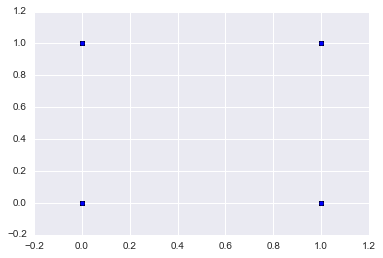

In [216]:
plt.scatter(y, predictions)

In [199]:
accuracy = metrics.accuracy_score(y, predictions)
print "Cross-Predicted Accuracy:", accuracy

Cross-Predicted Accuracy: 0.660377358491


#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [215]:
#Lasso
logiReg = LogisticRegression()
logiReg.penalty = "l1"
model = logiReg.fit(X,y)
predictions = model.predict(X)
print "Model score: ", model.score(X,y)

Model score:  0.794811320755


In [201]:
## YOUR CODE HERE
print "Accuracy score: ", accuracy_score(y,predictions)
print "Precision score: ", precision_score(y,predictions)
print "Recall score: ", recall_score(y,predictions)

Accuracy score:  0.799528301887
Precision score:  0.79274611399
Recall score:  0.772727272727


In [202]:
pd.crosstab(y,predictions)

col_0,0,1
Actual,,
0,186,40
1,45,153


In [203]:
# Ridge
logiReg = LogisticRegression()
logiReg.penalty = "l2"
model = logiReg.fit(X,y)
predictions = model.predict(X)
print "Model score: ", model.score(X,y)

Model score:  0.865566037736


In [204]:
print "Accuracy score: ", accuracy_score(y,predictions)
print "Precision score: ", precision_score(y,predictions)
print "Recall score: ", recall_score(y,predictions)

Accuracy score:  0.865566037736
Precision score:  0.885245901639
Recall score:  0.818181818182


In [205]:
pd.crosstab(y,predictions)

col_0,0,1
Actual,,
0,205,21
1,36,162


In [206]:
#coefficients
data.columns.values
model.coef_.ravel()

array([ 0.06189236,  0.27418853,  1.16247796,  0.18322976, -0.11592607,
       -0.39127175, -0.91693104,  0.42515028,  0.09663214,  0.35037567,
        0.23450384, -0.66529215, -0.53601396, -0.05899673,  0.70120453,
        1.3308165 ,  0.04307692,  0.66417583, -0.22370872,  0.51542351,
        0.1373645 ,  0.38784424, -0.1493876 ,  0.3437222 , -0.08314304,
       -0.33719166, -0.27161883,  0.38784424,  0.05841726,  0.05841726,
       -0.6264387 ,  0.05841726,  0.54287665,  0.05841726, -0.29484268,
        0.220941  , -0.61003395, -0.20071313, -0.22370872,  0.25593178,
        0.51542351,  1.27215016,  0.3423812 ,  0.68362295, -0.20095136,
       -0.9776129 ,  0.33644067, -0.53684257, -0.22926677,  0.51542351,
       -0.29484268, -0.29856619, -0.3864662 ,  0.24304682,  0.05841726,
        0.05841726, -0.10987936,  0.05841726,  0.15121945, -0.33257624,
       -0.22370872,  0.10642034, -0.22858518,  0.13598623,  0.05841726,
        0.14821098, -0.22370872, -0.27161883, -0.33924997, -0.22

In [207]:
model.intercept_

array([ 0.06854324])

In [208]:
def formatNumber(num):
    return '{:f}'.format(num)

In [232]:
scores, pvalues = chi2(X, y)

formatted = map(formatNumber,pvalues)

summary = pd.DataFrame({"Variables":data.columns.values[7:],"Coeffs":model.coef_.ravel(),"Coeffs_exp":np.exp(model.coef_.ravel()),"Pvalues":formatted})
summary.head()

,Coeffs,Coeffs_exp,Pvalues,Variables
0,0.000000,1.000000,0.134447,location_Atlanta
1,0.000000,1.000000,0.851510,location_Austin
2,1.706604,5.510218,0.032619,location_Charlotte
3,0.012103,1.012176,0.370924,location_Chicago
4,0.000000,1.000000,0.353426,location_Dallas


#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [ ]:
## YOUR CODE HERE

In [ ]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [ ]:
## YOUR CODE HERE